# HSBC ML Test  

Objective: Using Machine Learning to estimate the cost of transaction given a specific volume and time frame. This can help to estimate the transaction cost of a deal and understand the market liquidity. 

**Model input: Volume and time in hours

**Model output: transaction cost (bid_ask_spread)

I have completed the task with the following steps: 

1. Explore the data structure to assess the relationship of different dimensions within this dataset using data visualisation and some explosive test

2. Feature importance assessment based on either statistical methods, export knowledge or entropy based methods depending on the structure of data. 

3. Sample weights: Optimise the sample weights to ensure a wider coverage of events within the markets including some tail events. This include assess the uniqueness of sample and balance the weight of sample to avoid overfit

4. Model selection: select the approprate model to make prediction and back test the result 

5. Simulation, presentation and reporting

In [1]:
# import packages

import pandas as pd
import numpy as np
import sklearn
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# load dataset into the notebook

data = pd.read_csv(r'C:/Users/wangy/OneDrive/Desktop/Exercise/ABC_Level_One_Tick_Data.csv')

# Basic data processing: set datatime as index

data['Time_Hour']= pd.to_datetime(data['Time_Hour'])
data.set_index('Time_Hour', inplace = True)

# abstract the hour as a potential feature and encode to int
data['Time_Hour_2'] = data.index.hour.astype(int) - 6

# estimate market volatility and price change as a potential feature
data['volatility_prox'] = (data['High'] - data['Low'])/data['Open']

# Consolidate dataset 

data = data[['Time_Hour_2','NumberOfTrades','Volume','Turnover','volatility_prox','Avg_Bid_Ask_Spread']].dropna()

# Data Cleaning & Outlier Detection

<AxesSubplot:>

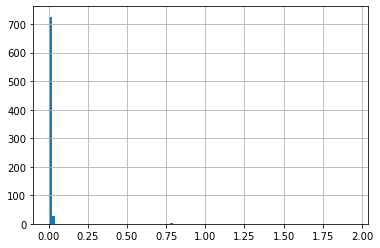

In [3]:
# filter out negative bid_ask spread as outlier as bid_ask spread should always be positive
# Explore the distribution of the bid_ask spread. 
# It seems the distribution is a long tail distribution. In that case, we normally need to check with the experts if the tail value is valid. 
# Here we assume the tail value is not outliers to aviod ignoring tail risk (low probability but significant events) 
# Of course, if experts have confirmed that those data points are outliers, we can remove them

data = data[data['Avg_Bid_Ask_Spread'] >=0]

data.Avg_Bid_Ask_Spread.hist(bins = 100)

<AxesSubplot:>

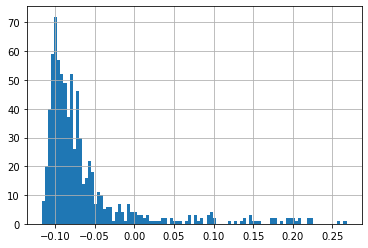

In [4]:
# Use isolation forest to detect potential outliers 
# we will not remove those potential outliers without checking with experts to avoid missing tail risk.

from pyod.models.iforest import IForest

clf = IForest()
clf.fit(data)

# get outlier scores

data['Outlier_score'] = clf.decision_scores_
data.Outlier_score.hist(bins = 100)

# Explore data structure

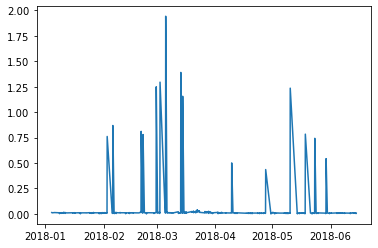

In [5]:
plt.plot(data.Avg_Bid_Ask_Spread)

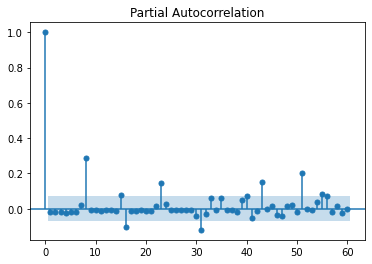

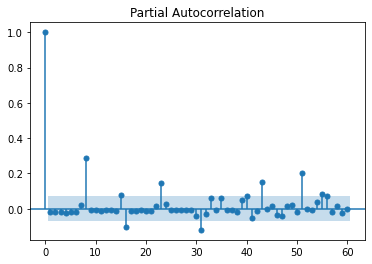

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data.Avg_Bid_Ask_Spread, lags=60)

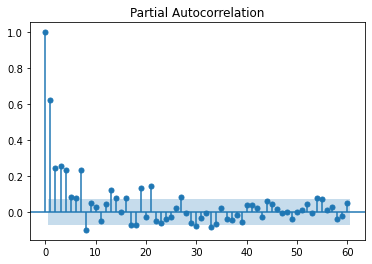

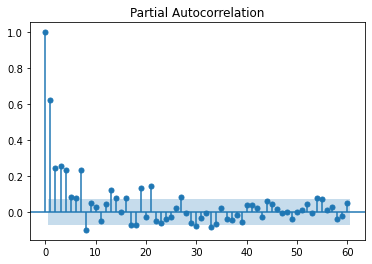

In [7]:
plot_pacf(data[data['Avg_Bid_Ask_Spread']<=0.1]['Avg_Bid_Ask_Spread'], lags=60)

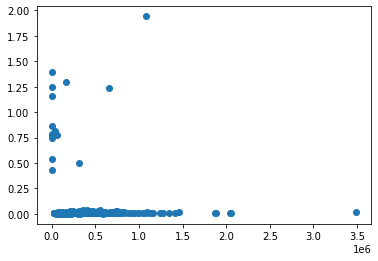

In [8]:
plt.scatter(data.Volume,data.Avg_Bid_Ask_Spread)

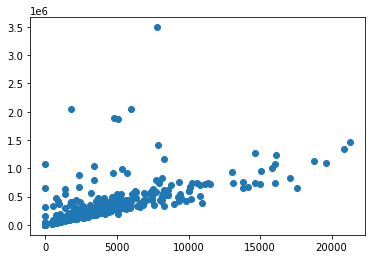

In [9]:
plt.scatter(data.NumberOfTrades,data.Volume)

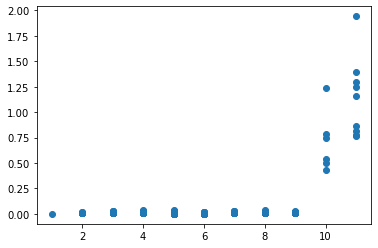

In [10]:
plt.scatter(data.Time_Hour_2,data.Avg_Bid_Ask_Spread)

In [11]:
# shape of the data looks very smilar across different dimensions, need to test data redandancy via PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler # reduce the impact of outliers

pca = PCA(n_components=3)
pca.fit_transform(RobustScaler().fit_transform(data[['NumberOfTrades','Volume','Turnover','volatility_prox']]))
print(pca.explained_variance_ratio_)

[0.87820226 0.10624813 0.01506365]


In [12]:
# assess the relationship between those dimensions
# also it can be seems that the linear relationship between features and spread is very weak

l = ['NumberOfTrades','Volume','Turnover','volatility_prox','Time_Hour_2','Avg_Bid_Ask_Spread']
correlation = pd.DataFrame(RobustScaler().fit_transform(data[['NumberOfTrades','Volume','Turnover','volatility_prox','Time_Hour_2','Avg_Bid_Ask_Spread']])).corr()
correlation.columns = l
correlation.index = l
correlation

,NumberOfTrades,Volume,Turnover,volatility_prox,Time_Hour_2,Avg_Bid_Ask_Spread
NumberOfTrades,1.000000,0.697376,0.680745,0.169116,0.199949,-0.130935
Volume,0.697376,1.000000,0.988988,0.176912,0.201580,-0.002330
Turnover,0.680745,0.988988,1.000000,0.170832,0.221931,0.004289
volatility_prox,0.169116,0.176912,0.170832,1.000000,-0.016037,-0.029122
Time_Hour_2,0.199949,0.201580,0.221931,-0.016037,1.000000,0.301939
Avg_Bid_Ask_Spread,-0.130935,-0.002330,0.004289,-0.029122,0.301939,1.000000


In [13]:
# Findings: 
# there are some structure within the time series 
# The features of'NumberOfTrades','Volume','Turnover','volatility_prox' seems contain very similar information. Therefore only one of them are needed or can run PCA to reduce the dimension
# Time_Hour_2 contain useful information. When the trade occurs will impact the cost and trading in the last two hours seems very expensive as the markets looks very iliquid

# Feature Importance



In [14]:
X = data[['NumberOfTrades','Volume','Turnover','volatility_prox','Time_Hour_2']]
y = data['Avg_Bid_Ask_Spread']

In [15]:
# test feature importance based on entropy method due to the structure of data

def feature_importance(X,y):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    regr = RandomForestRegressor(max_depth=4, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    regr.fit(X_train, y_train)
    
    return regr.feature_importances_ 

In [16]:
# evaluate the feature importance via emtropy method

feature_importance(X,y)

array([0.21232932, 0.11904445, 0.09229185, 0.11306505, 0.46326932])

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

X_new = SelectKBest(mutual_info_regression, k=4).fit_transform(X, y)

In [18]:
X_new

array([[1.36800000e+03, 7.78171818e+04, 4.86332376e-03, 3.00000000e+00],
       [9.09000000e+02, 5.81917273e+04, 1.84223748e-03, 4.00000000e+00],
       [5.01000000e+02, 3.47620909e+04, 2.84900276e-03, 5.00000000e+00],
       ...,
       [3.52700000e+03, 1.82950454e+05, 8.96425303e-03, 6.00000000e+00],
       [5.37500000e+03, 2.99565364e+05, 1.09354414e-02, 7.00000000e+00],
       [5.47000000e+03, 3.02952818e+05, 9.75193587e-03, 8.00000000e+00]])

In [19]:
# Conslusion: 

# 'Volume' and 'Time_Hour_2' can be selected as features based on the conclusion of mutual information and emtropy method
# Number of trades can be added, but seems doesn't impact too much as it contains similar information with volume based on PCA analysis

# Sample Weight Optimisation

The bid_ask spread has a long tail which can contain several low probability but signification events. In order to ensure that the model can also capture those events the sample has to be balanced so that the prediction will not over fit and ignore those tail risks.

Ideally, we should also have market events data such as covid or other significant market event to ensure that the sample has a more balanced coverage of different market situations. However, as we don't have events data, I will apply the clustering technique to assess the similarity of the sample data ( test sample uniqueness) and then rebalance the dataset. 

<AxesSubplot:>

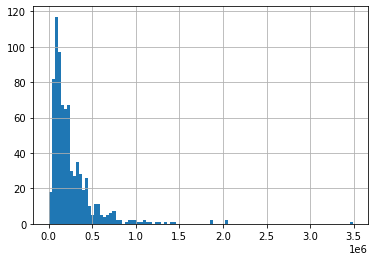

In [20]:
# check the distribution of sample data

data.Volume.hist(bins = 100)

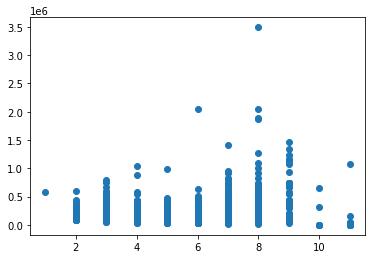

In [21]:
plt.scatter(data.Time_Hour_2, data.Volume)

In [22]:
data.Time_Hour_2.value_counts()

8     112
7     112
3     110
4     109
5     103
6      95
9      62
2      50
11      9
10      6
1       1
Name: Time_Hour_2, dtype: int64

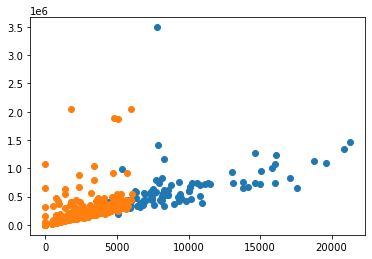

In [23]:
# using clustering to lable sample into different groups and then balance each sample size. Here none Eu

from sklearn.cluster import AgglomerativeClustering

data['Cluster'] = AgglomerativeClustering(n_clusters = 2).fit_predict(RobustScaler().fit_transform(data[['NumberOfTrades','Time_Hour_2']]))

plt.scatter(data[data['Cluster']==1]['NumberOfTrades'],data[data['Cluster']==1]['Volume'])
plt.scatter(data[data['Cluster']==0]['NumberOfTrades'],data[data['Cluster']==0]['Volume'])

In [24]:
data.Cluster.value_counts()

0    640
1    129
Name: Cluster, dtype: int64

In [25]:
# applying the imbalance learning technique to optimise imbalanced sample

import imblearn

X1 = data[['NumberOfTrades','Volume','volatility_prox','Time_Hour_2','Avg_Bid_Ask_Spread']]
y1 = data['Cluster']

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', k_neighbors=3)
X_sm, y_sm = smote.fit_resample(X1, y1)

# X_sm will be used as the new dataset

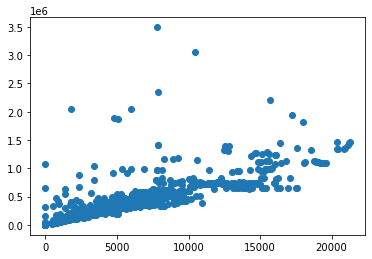

In [26]:
plt.scatter(X_sm['NumberOfTrades'],X_sm['Volume'])

# Building the prediction Model

In [27]:
# as the linear relationship between input and output is not clear, apply random forest as predictor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

X2 = X_sm[['Volume','Time_Hour_2']]
y2 = X_sm['Avg_Bid_Ask_Spread']

regr = RandomForestRegressor(max_depth=4, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.4, random_state=0)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.9301337920153319

In [28]:
# parameter optimization with GridSearch

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [1, 2, 3, 4, 10],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [0, 100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X2, y2)

grid_search.best_params_

Fitting 3 folds for each of 450 candidates, totalling 1350 fits


C:\Users\wangy\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.13028995 0.13806358 0.13254974 0.12970092        nan
 0.11586988 0.12953678 0.13757024 0.1334157         nan 0.1245354
 0.14562497 0.12862083 0.13438954        nan 0.0642511  0.10181749
 0.09295756 0.0924231         nan 0.0752313  0.10698699 0.08855727
 0.10041547        nan 0.10709693 0.09400934 0.09228695 0.09925453
        nan 0.03545298 0.06830804 0.05283734 0.05485574        nan
 0.0636998  0.04103814 0.05039944 0.04893056        nan 0.05357112
 0.06069106 0.0564538  0.04784519        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        na

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [29]:
regr = RandomForestRegressor(max_depth=10, random_state=0, n_estimators = 1000, bootstrap=True)

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.4, random_state=0)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.9344296222540478

In [30]:
regr.score(X_train, y_train)

0.9769480062032573

# Predict the cost of execution:

1. The volume is assumed as 3490824
2. Random simulate execution time between 1 to 11 hours
3. Assume the trade starts at 7 am

In [31]:
execution = pd.DataFrame(list(range(1,12)))
execution['Time_Clock'] = execution[0] + 7
execution['Volume'] = 94900
execution['Volume_Per_Hour'] = execution['Volume'] / execution[0]
execution.columns = ['Time_Hours','Time_Clock','Volume','Volume_Per_Hour']

In [32]:
execution

,Time_Hours,Time_Clock,Volume,Volume_Per_Hour
0,1,8,94900,94900.000000
1,2,9,94900,47450.000000
2,3,10,94900,31633.333333
3,4,11,94900,23725.000000
4,5,12,94900,18980.000000
5,6,13,94900,15816.666667
6,7,14,94900,13557.142857
7,8,15,94900,11862.500000
8,9,16,94900,10544.444444
9,10,17,94900,9490.000000


In [33]:
# Predict the cost of transaction for a given volume and time 

execution['Cost_Prediction'] =  regr.predict(execution[['Volume_Per_Hour','Time_Hours']])

In [34]:
execution['Cost_Prediction']

0     0.009548
1     0.009558
2     0.010566
3     0.010536
4     0.010207
5     0.012724
6     0.017808
7     0.017727
8     0.025065
9     0.534787
10    0.819239
Name: Cost_Prediction, dtype: float64

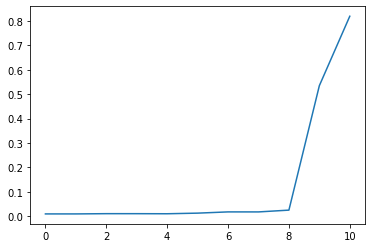

In [35]:
# It seems that when traded have a big impact

plt.plot(execution.Cost_Prediction)

In [36]:
# Estimate the cost of transaction conducted during different time of the date to mitigate the impact of trade clock

Test = pd.read_excel(r'C:/Users/wangy/OneDrive/Desktop/Exercise/Test.xlsx')

In [37]:
Test

,Time_Hours,Time_Clock_7,Time_Clock_8,Time_Clock_9,Time_Clock_10,Time_Clock_11,Time_Clock_12,Time_Clock_13,Time_Clock_14,Time_Clock_15,Time_Clock_16,Time_Clock_17,Volume,Volume_Per_Hour
0,1,1,2,3,4,5,6,7,8,9,10,11,949000,949000.000000
1,2,1,2,3,4,5,6,7,8,9,10,11,949000,474500.000000
2,3,1,2,3,4,5,6,7,8,9,10,11,949000,316333.333333
3,4,1,2,3,4,5,6,7,8,9,10,11,949000,237250.000000
4,5,1,2,3,4,5,6,7,8,9,10,11,949000,189800.000000
5,6,1,2,3,4,5,6,7,8,9,10,11,949000,158166.666667
6,7,1,2,3,4,5,6,7,8,9,10,11,949000,135571.428571
7,8,1,2,3,4,5,6,7,8,9,10,11,949000,118625.000000
8,9,1,2,3,4,5,6,7,8,9,10,11,949000,105444.444444
9,10,1,2,3,4,5,6,7,8,9,10,11,949000,94900.000000


In [38]:
X7 = Test[['Volume_Per_Hour','Time_Clock_7']]
X8 = Test[['Volume_Per_Hour','Time_Clock_8']]
X9 = Test[['Volume_Per_Hour','Time_Clock_9']]
X10 = Test[['Volume_Per_Hour','Time_Clock_10']]
X11 = Test[['Volume_Per_Hour','Time_Clock_11']]
X12 = Test[['Volume_Per_Hour','Time_Clock_12']]
X13 = Test[['Volume_Per_Hour','Time_Clock_13']]
X14 = Test[['Volume_Per_Hour','Time_Clock_14']]
X15 = Test[['Volume_Per_Hour','Time_Clock_15']]
X16 = Test[['Volume_Per_Hour','Time_Clock_16']]
X17 = Test[['Volume_Per_Hour','Time_Clock_17']]

In [39]:
Test['Prediction_7'] = regr.predict(X7)
Test['Prediction_8'] = regr.predict(X8)
Test['Prediction_9'] = regr.predict(X9)
Test['Prediction_10'] = regr.predict(X10)
Test['Prediction_11'] = regr.predict(X11)
Test['Prediction_12'] = regr.predict(X12)
Test['Prediction_13'] = regr.predict(X13)
Test['Prediction_14'] = regr.predict(X14)
Test['Prediction_15'] = regr.predict(X15)
Test['Prediction_16'] = regr.predict(X16)
Test['Prediction_17'] = regr.predict(X17)

In [41]:
result = Test.loc[:, 'Prediction_7':'Prediction_17']
result['Time_Hours'] = Test['Time_Hours']

In [42]:
result

,Prediction_7,Prediction_8,Prediction_9,Prediction_10,Prediction_11,Prediction_12,Prediction_13,Prediction_14,Prediction_15,Prediction_16,Prediction_17,Time_Hours
0,0.011911,0.011911,0.014267,0.013964,0.011584,0.010363,0.010768,0.011024,0.010719,1.221400,1.678160,1
1,0.014852,0.014852,0.026292,0.023980,0.021299,0.018118,0.017261,0.017073,0.017075,0.616876,1.059002,2
2,0.014029,0.014029,0.015139,0.016016,0.014253,0.011388,0.011166,0.011108,0.011217,0.584668,1.033997,3
3,0.009368,0.009368,0.009650,0.010080,0.007299,0.008704,0.009270,0.009694,0.010220,0.648815,1.098266,4
4,0.009867,0.009867,0.009801,0.010664,0.006458,0.007963,0.008843,0.008682,0.010099,0.648795,1.098266,5
5,0.009252,0.009252,0.009082,0.009467,0.005710,0.007580,0.012503,0.012276,0.012536,0.634194,1.108902,6
6,0.008781,0.008781,0.008695,0.008648,0.006615,0.007977,0.011054,0.011568,0.011541,0.634105,1.108899,7
7,0.009559,0.009559,0.010141,0.009974,0.004055,0.008516,0.011171,0.011490,0.011234,0.634083,1.108899,8
8,0.009479,0.009479,0.010280,0.009858,0.007800,0.008317,0.010483,0.010779,0.010620,0.556916,0.902534,9
9,0.009548,0.009548,0.010576,0.010110,0.010393,0.008333,0.010908,0.010922,0.010836,0.525198,0.832454,10


In [43]:
result.columns = ['Trade_7_am','Trade_8_am','Trade_9_am','Trade_10_am','Trade_11_am','Trade_12_am','Trade_13_pm','Trade_14_pm','Trade_15_pm','Trade_16_pm','Trade_17_pm','Time_Hours']
result = result[['Time_Hours','Trade_7_am','Trade_8_am','Trade_9_am','Trade_10_am','Trade_11_am','Trade_12_am','Trade_13_pm','Trade_14_pm','Trade_15_pm','Trade_16_pm','Trade_17_pm']]
result

,Time_Hours,Trade_7_am,Trade_8_am,Trade_9_am,Trade_10_am,Trade_11_am,Trade_12_am,Trade_13_pm,Trade_14_pm,Trade_15_pm,Trade_16_pm,Trade_17_pm
0,1,0.011911,0.011911,0.014267,0.013964,0.011584,0.010363,0.010768,0.011024,0.010719,1.221400,1.678160
1,2,0.014852,0.014852,0.026292,0.023980,0.021299,0.018118,0.017261,0.017073,0.017075,0.616876,1.059002
2,3,0.014029,0.014029,0.015139,0.016016,0.014253,0.011388,0.011166,0.011108,0.011217,0.584668,1.033997
3,4,0.009368,0.009368,0.009650,0.010080,0.007299,0.008704,0.009270,0.009694,0.010220,0.648815,1.098266
4,5,0.009867,0.009867,0.009801,0.010664,0.006458,0.007963,0.008843,0.008682,0.010099,0.648795,1.098266
5,6,0.009252,0.009252,0.009082,0.009467,0.005710,0.007580,0.012503,0.012276,0.012536,0.634194,1.108902
6,7,0.008781,0.008781,0.008695,0.008648,0.006615,0.007977,0.011054,0.011568,0.011541,0.634105,1.108899
7,8,0.009559,0.009559,0.010141,0.009974,0.004055,0.008516,0.011171,0.011490,0.011234,0.634083,1.108899
8,9,0.009479,0.009479,0.010280,0.009858,0.007800,0.008317,0.010483,0.010779,0.010620,0.556916,0.902534
9,10,0.009548,0.009548,0.010576,0.010110,0.010393,0.008333,0.010908,0.010922,0.010836,0.525198,0.832454


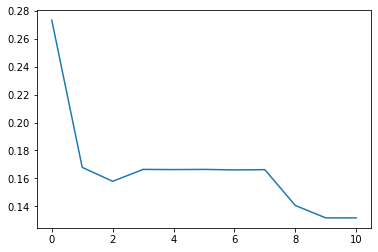

In [75]:
# plot the transaction cost for different time from 1-11 hours

plt.plot(result.transpose()[1:].mean())

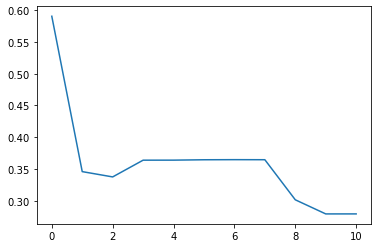

In [76]:
plt.plot(result.transpose()[1:].std())

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>],
       [<AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>, <AxesSubplot:>]],
      dtype=object)

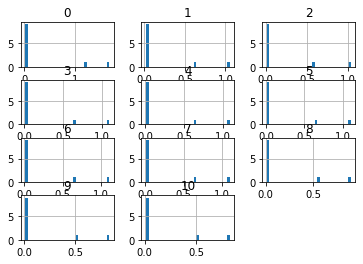

In [59]:
# plot the cost distribution across different time from 1-11 hours

result.transpose()[1:].hist(bins = 30)

In [44]:
result.to_excel('result.xlsx')